In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_05.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_04.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_08.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_01.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_02.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_03.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_07.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_09.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_06.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_17/v_biking_17_03.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking

## Importing Libraries


In [2]:
import tensorflow as tf
import keras
import cv2
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, ConvLSTM3D,AveragePooling3D, MaxPooling3D,Input
from tensorflow.keras.layers import Bidirectional, ConvLSTM2D,AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, ZeroPadding3D,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam,Adagrad,Adadelta,SGD
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.c3d import C3D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2,l1,l1_l2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical,plot_model
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_dir = '/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg'
categories = os.listdir(data_dir)
num_classes = len(categories)


In [4]:
categories

['biking',
 'trampoline_jumping',
 'swing',
 'walking',
 'golf_swing',
 'soccer_juggling',
 'tennis_swing',
 'volleyball_spiking',
 'basketball',
 'horse_riding',
 'diving']

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm


SEQUENCE_LENGTH = 10
DIM=(96,96)

def load_groups(input_folder):
    groups = []
    label_folders = os.listdir(input_folder)
    index = 0
    for label_folder in sorted(label_folders):
        label_folder_path = os.path.join(input_folder, label_folder)
        if os.path.isdir(label_folder_path):
            group_folders = os.listdir(label_folder_path)
            for group_folder in group_folders:
                if group_folder != 'Annotation':
                    groups.append([os.path.join(label_folder_path, group_folder), label_folder])
            index += 1
    return groups

def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, DIM)
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list


def split_into_train_test(groups):
    data = []
    labels = []
    original_labels=[]
    label_to_index = {}  # Create a mapping from labels to integer indices
    index_to_label = {}  # Create a reverse mapping from integer indices to labels

    for group in tqdm(groups):
        video_files = os.listdir(group[0])
        np.random.shuffle(video_files)
        for idx, video_file in enumerate(video_files):
            video_file_path = os.path.abspath(os.path.join(group[0], video_file))
            frames = frames_extraction(video_file_path)  # Extract frames from video
            if len(frames) == SEQUENCE_LENGTH:
                data.append(frames)
                label = group[1]
                original_labels.append(label)
                if label not in label_to_index:
                    index = len(label_to_index)
                    label_to_index[label] = index
                    index_to_label[index] = label
                labels.append(label_to_index[label])

    num_classes = len(label_to_index)
    data=np.asarray(data)
    label = np.array(label)

    encoded_labels = to_categorical(labels, num_classes=num_classes)

    # Split data and labelsencoded_labels
    train_data, test_data, train_labels, test_labels = train_test_split(data, encoded_labels, test_size=0.2, random_state=19, stratify=encoded_labels)

    return train_data, test_data, train_labels, test_labels, original_labels, encoded_labels


def make_csv_file(items, labels, file_path):
    items =[ item.reshape(-1) for item in items]
    labels = [ label.reshape(-1) for label in labels]
    data = {'Video_Frames': items, 'Label': labels}
    df = pd.DataFrame(data)
    df.to_csv(file_path, index=False)



In [6]:
groups = load_groups(data_dir)

In [7]:
train_data, test_data, train_labels, test_labels, original_labels, encoded_labels = split_into_train_test(groups)

100%|██████████| 275/275 [01:21<00:00,  3.36it/s]


In [8]:
make_csv_file(train_data, train_labels, 'final_train_data.csv')
make_csv_file(test_data, test_labels, 'final_test_data.csv')

## Data Visualization of Dataset


In [9]:
train_df = pd.read_csv("/kaggle/working/final_train_data.csv")
test_df = pd.read_csv("/kaggle/working/final_test_data.csv")

In [10]:
train_df.columns,test_df.columns

(Index(['Video_Frames', 'Label'], dtype='object'),
 Index(['Video_Frames', 'Label'], dtype='object'))

In [11]:
train_df.head

<bound method NDFrame.head of                                            Video_Frames  \
0                               [0. 0. 0. ... 0. 0. 0.]   
1     [0.21176471 0.23137255 0.23137255 ... 0.372549...   
2     [0.         0.03529412 0.03137255 ... 0.141176...   
3                               [0. 0. 0. ... 0. 0. 0.]   
4     [0.40392157 0.41568627 0.37647059 ... 0.160784...   
...                                                 ...   
1272                            [0. 0. 0. ... 0. 0. 0.]   
1273  [1.         0.92941176 0.78823529 ... 0.156862...   
1274  [0.36470588 0.30980392 0.28235294 ... 0.784313...   
1275  [0.8        0.69803922 0.85882353 ... 0.698039...   
1276  [0.03137255 0.03137255 0.03137255 ... 0.309803...   

                                   Label  
0     [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]  
1     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  
2     [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]  
3     [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  
4     [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]  
...

In [12]:
test_df.head

<bound method NDFrame.head of                                           Video_Frames  \
0                              [0. 0. 0. ... 0. 0. 0.]   
1                              [0. 0. 0. ... 0. 0. 0.]   
2    [0.77254902 0.7254902  0.67058824 ... 0.6     ...   
3                              [0. 0. 0. ... 0. 0. 0.]   
4    [0.73333333 0.78823529 0.78823529 ... 0.015686...   
..                                                 ...   
315                            [0. 0. 0. ... 0. 0. 0.]   
316  [0.29803922 0.34509804 0.33333333 ... 0.596078...   
317  [0.00392157 0.00392157 0.00392157 ... 0.258823...   
318  [0.77647059 0.76862745 0.82352941 ... 0.349019...   
319  [0.03921569 0.04313725 0.         ... 0.113725...   

                                  Label  
0    [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]  
1    [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]  
2    [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]  
3    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]  
4    [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  
..                   

In [13]:
print(f"Dimension of Training Datset is : {train_df.shape}")
print(f"Dimension of Training Datset is : {test_df.shape}")

Dimension of Training Datset is : (1277, 2)
Dimension of Training Datset is : (320, 2)


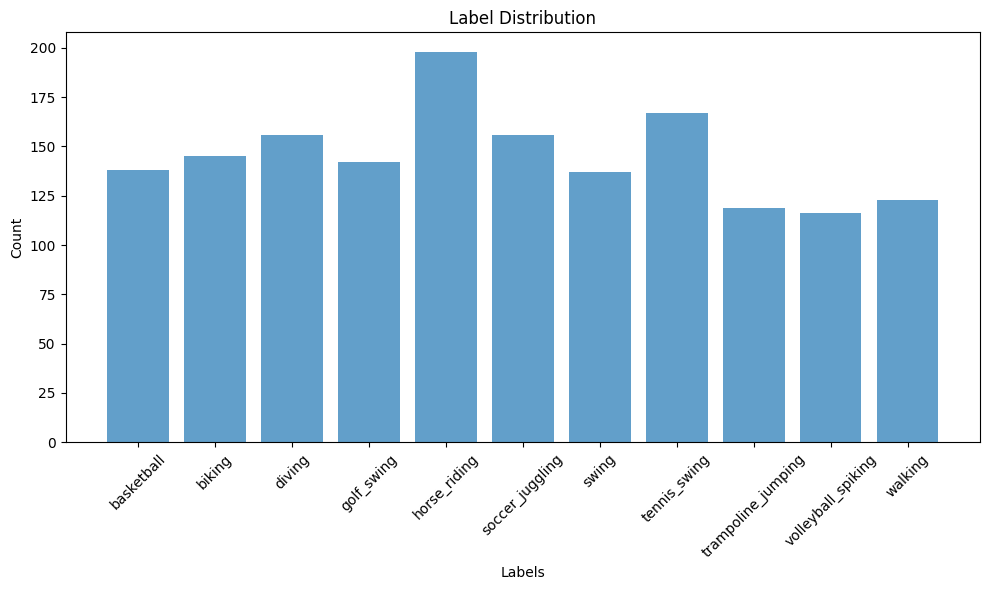

In [14]:
from collections import Counter

def create_bar_plot(labels):
    # Count the occurrences of each unique label
    label_counts = Counter(labels)
    
    # Get the unique labels and their counts
    unique_labels, counts = zip(*label_counts.items())

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, align='center', alpha=0.7)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()

    plt.show()
    
create_bar_plot(original_labels)

## Making CNN+LSTM Model for Training 

##### Defining the Dimesnsion of input

In [15]:
frames = SEQUENCE_LENGTH   
height = DIM[0]
width = DIM[1]
num_classes=11

In [16]:
def SEQ_Model():
    model = Sequential()
    
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(frames, height, width, 3),
                         strides=(1, 1), padding='same', activation='tanh', return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), input_shape=(frames, height, width, 3),
                         strides=(1, 1), padding='same', activation='tanh', return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='tanh', return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='tanh', return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten())  
    

    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2=0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(2024, activation='relu', kernel_regularizer=l2(l2=0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.summary()
    
    return model
    

In [17]:
print("Model Architecture : ")
# final_model = I3d_architecture(frames, height, width, num_classes)
final_model= SEQ_Model()

Model Architecture : 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 10, 96, 96, 32)    40448     
                                                                 
 batch_normalization (BatchN  (None, 10, 96, 96, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 48, 48, 32)   0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 10, 48, 48, 32)   0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 10, 48, 48, 64)    221440    
                                  

## Structure of Model Architecture

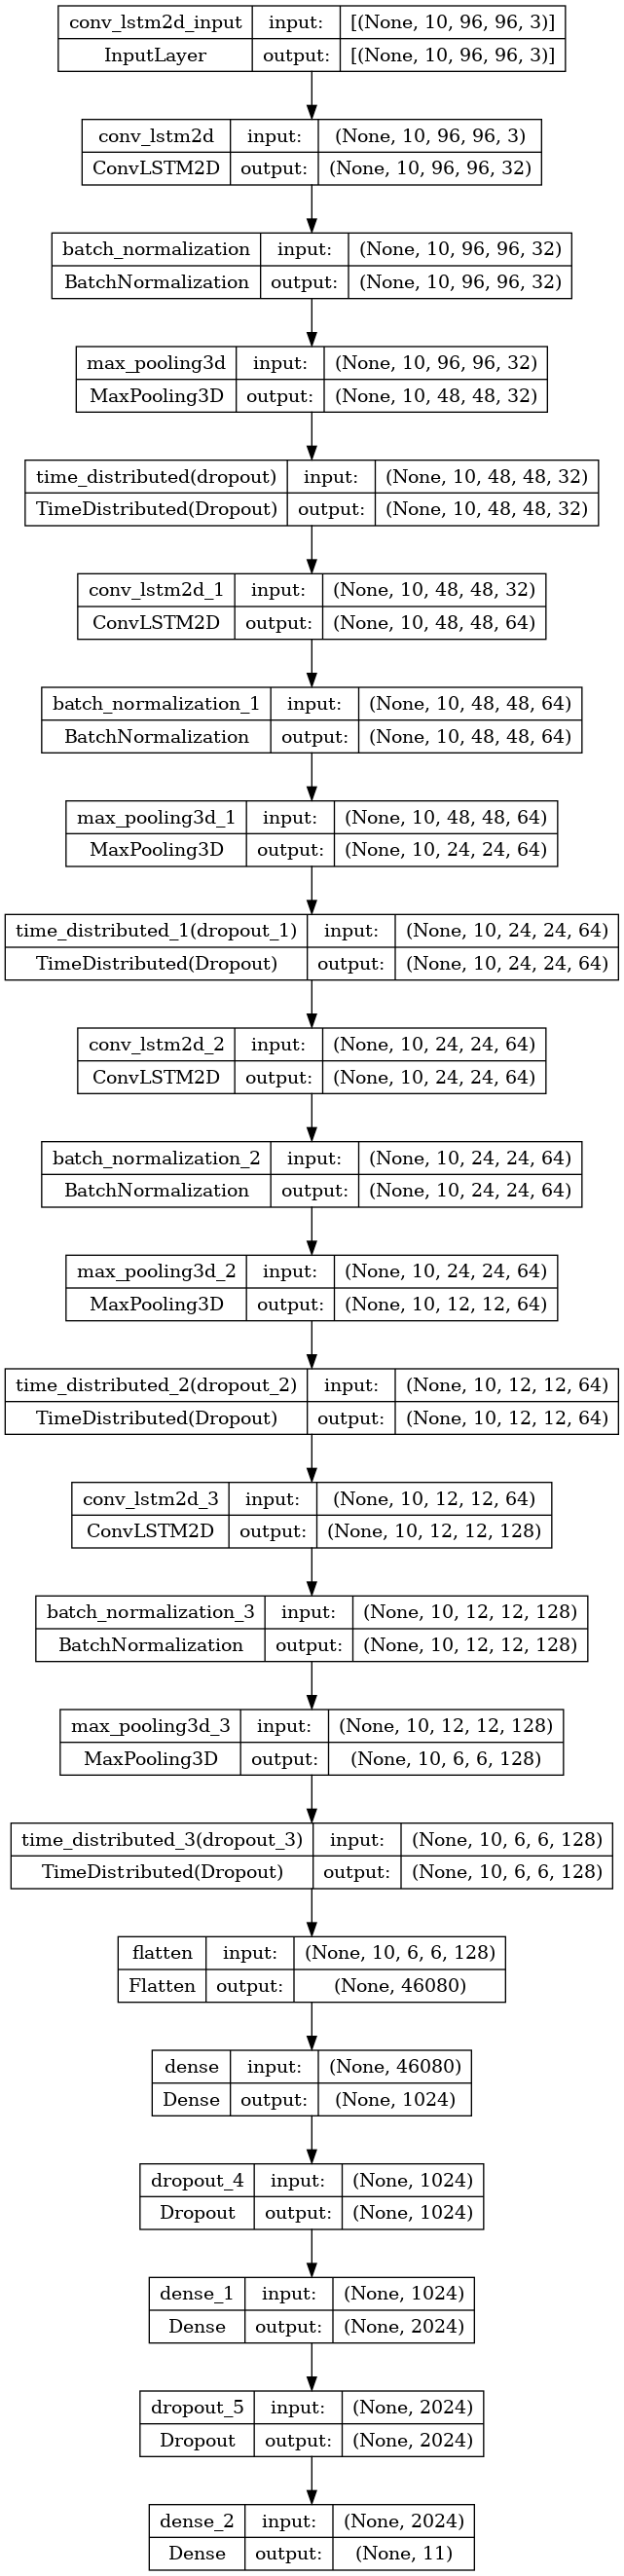

In [18]:
model_str = plot_model(final_model, to_file='model.png', show_shapes=True, show_layer_names=True)
model_str

## Compile and Train the Model

In [19]:
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

final_model.compile(optimizer=optimizer,  
              loss='categorical_crossentropy', 
              metrics=['accuracy'])  

model_history = final_model.fit(
    train_data,
    train_labels,
    batch_size=25,
    epochs=150,
    verbose='auto',
    validation_split = 0.2,
    shuffle=True,
    use_multiprocessing=True,
    callbacks=early_stopper
)

Epoch 1/150


2023-10-08 19:23:21.782168: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/dropout_3/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 73s 1s/step - loss: 36.2097 - accuracy: 0.1802 - val_loss: 35.5577 - val_accuracy: 0.3008
Epoch 2/150
41/41 [==============================] - 52s 1s/step - loss: 35.6409 - accuracy: 0.2909 - val_loss: 35.2858 - val_accuracy: 0.3984
Epoch 3/150
41/41 [==============================] - 51s 1s/step - loss: 35.3344 - accuracy: 0.3761 - val_loss: 35.2667 - val_accuracy: 0.3633
Epoch 4/150
41/41 [==============================] - 52s 1s/step - loss: 35.1486 - accuracy: 0.4163 - val_loss: 34.9565 - val_accuracy: 0.4727
Epoch 5/150
41/41 [==============================] - 51s 1s/step - loss: 34.9365 - accuracy: 0.4721 - val_loss: 34.8494 - val_accuracy: 0.5117
Epoch 6/150
41/41 [==============================] - 50s 1s/step - loss: 34.7631 - accuracy: 0.5142 - val_loss: 34.9772 - val_accuracy: 0.4570
Epoch 7/150
41/41 [==============================] - 52s 1s/step - loss: 34.5702 - accuracy: 0.5485 - val_loss: 34.6567 - val_accuracy: 0.5312
Epoch 8/150

## Model Evaluation


In [20]:
test_loss,test_accuracy = final_model.evaluate(test_data,test_labels)

10/10 [==============================] - 4s 378ms/step - loss: 27.0406 - accuracy: 0.8156


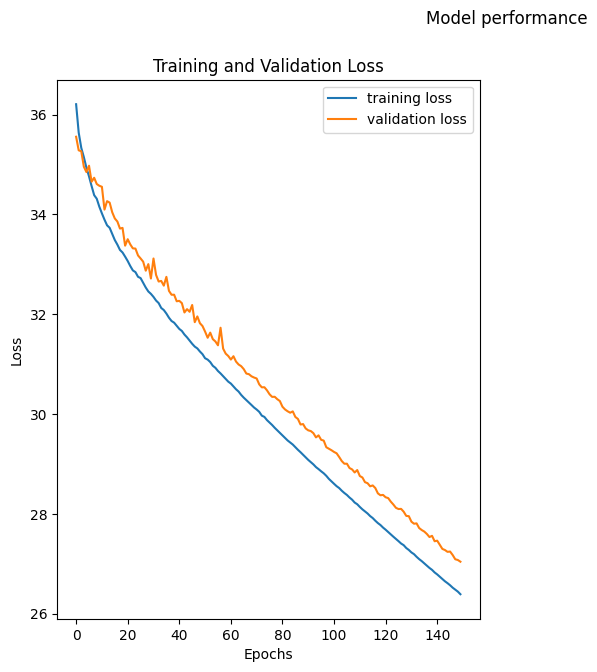

In [21]:
plt.figure(figsize=(12,7))
plt.suptitle("Model performance")

plt.subplot(1, 2, 1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.plot(model_history.history["loss"], label="training loss")
plt.plot(model_history.history["val_loss"], label="validation loss")
plt.legend()


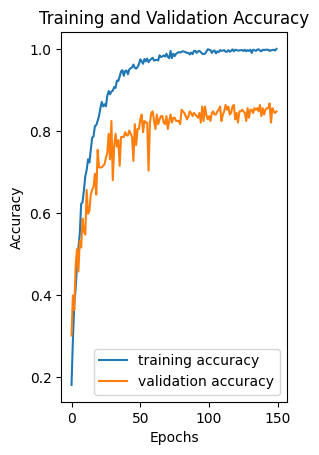

In [22]:
plt.subplot(1, 2, 2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')
plt.plot(model_history.history['accuracy'], label="training accuracy")
plt.plot(model_history.history['val_accuracy'], label="validation accuracy")
plt.legend()
plt.show()

In [23]:
SGD_HAR3 = final_model.save("SGD3.h5")
SGD_HAR_wt3 = final_model.save_weights("wt6.h5")



In [24]:

class_labels = ["basketball", "biking", "diving", "golf", "horse_riding",
                "soccer_juggling", "swing", "tennis_swing", "trampoline_jumping",
                "volleyball_spiking", "walking"]

def predict_single_action(input_video_file_path, SEQUENCE_LENGTH):
    frames = frames_extraction(input_video_file_path)
    frames = np.asarray(frames)
    frames = frames.reshape(-1, SEQUENCE_LENGTH, DIM[0], DIM[1], 3)
    
    prediction = final_model.predict(frames)
    predicted_label = np.argmax(prediction, axis=1)
    
    print("Predicted label: ", predicted_label[0])
    print("Predicted Action: ", class_labels[predicted_label[0]])
    
    return predicted_label[0]

input_video_file_path = '/kaggle/input/testdata/y2mate.com -  100 MPH Forehand Winner   Shorts_1080pFHR.mp4'

final_output = predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

1/1 [==============================] - 1s 1s/step
Predicted label:  4
Predicted Action:  horse_riding


10/10 [==============================] - 4s 375ms/step
[[23  1  0  0  2  0  0  1  0  0  1]
 [ 0 19  0  0  4  2  0  0  0  0  4]
 [ 1  0 27  0  0  0  0  0  0  0  3]
 [ 0  1  0 23  3  0  0  1  0  0  0]
 [ 0  5  0  0 34  0  1  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  1]
 [ 0  3  0  1  2  1 19  0  0  0  1]
 [ 0  3  0  0  0  0  0 31  0  0  0]
 [ 0  5  0  0  0  0  1  0 18  0  0]
 [ 0  1  0  0  1  0  0  0  0 21  0]
 [ 0  7  0  0  0  2  0  0  0  0 16]]


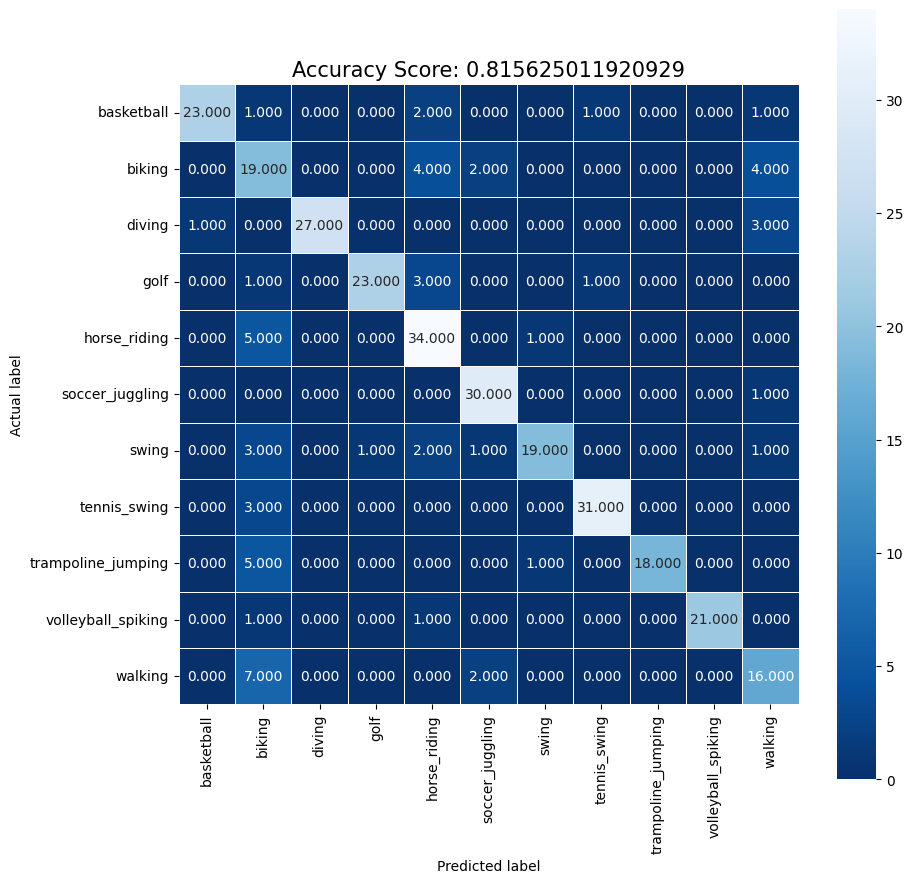

In [25]:
# confusion matrix in range 0 to 1 and us original labels at graph at display martix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ["basketball", "biking", "diving", "golf", "horse_riding",
                "soccer_juggling", "swing", "tennis_swing", "trampoline_jumping",
                "volleyball_spiking", "walking"]

predicted_label = final_model.predict(test_data)
predicted_label = np.argmax(predicted_label, axis=1)

# Classification metrics can't handle a mix of multilabel-indicator and binary targets

cm = confusion_matrix(test_labels.argmax(axis=1), predicted_label)
print(cm)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r',xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(test_accuracy)
plt.title(all_sample_title, size=15)
plt.show()
